# Derive models of spacecraft with star tracker

Do all imports.

In [3]:
import sympy as sym
import numpy as np

# The `sympy.physics.mechanics` module makes it easier to work with (and display) time derivatives.
from sympy.physics import mechanics
mechanics.init_vprinting()

## Dynamic model

Specify the physical parameters:

In [4]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the equations of motion:

In [5]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

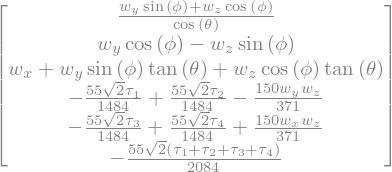

In [6]:
f

## Sensor model

Symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star:

In [7]:
alpha, delta = sym.symbols('alpha, delta')

Specify the physical parameters:

In [8]:
# Scope radius
r = 0.8 / 2.1

Derive the sensor model:

In [9]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

Here is the function $g$:

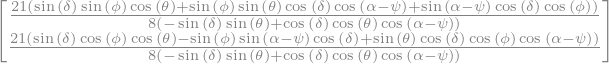

In [10]:
g

### Display $f$ and $g$ as latex-formatted text that could be copy/pasted into a $\LaTeX$ document (or into markdown).

In [11]:
print(f'{mechanics.mlatex(f)}')

\left[\begin{matrix}\frac{w_{y} \sin{\left(\phi \right)} + w_{z} \cos{\left(\phi \right)}}{\cos{\left(\theta \right)}}\\w_{y} \cos{\left(\phi \right)} - w_{z} \sin{\left(\phi \right)}\\w_{x} + w_{y} \sin{\left(\phi \right)} \tan{\left(\theta \right)} + w_{z} \cos{\left(\phi \right)} \tan{\left(\theta \right)}\\- \frac{55 \sqrt{2} \tau_{1}}{1484} + \frac{55 \sqrt{2} \tau_{2}}{1484} - \frac{150 w_{y} w_{z}}{371}\\- \frac{55 \sqrt{2} \tau_{3}}{1484} + \frac{55 \sqrt{2} \tau_{4}}{1484} + \frac{150 w_{x} w_{z}}{371}\\- \frac{55 \sqrt{2} \left(\tau_{1} + \tau_{2} + \tau_{3} + \tau_{4}\right)}{2084}\end{matrix}\right]


In [12]:
print(f'{mechanics.mlatex(g)}')

\left[\begin{matrix}\frac{21 \left(\sin{\left(\delta \right)} \sin{\left(\phi \right)} \cos{\left(\theta \right)} + \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\delta \right)} \cos{\left(\alpha - \psi \right)} + \sin{\left(\alpha - \psi \right)} \cos{\left(\delta \right)} \cos{\left(\phi \right)}\right)}{8 \left(- \sin{\left(\delta \right)} \sin{\left(\theta \right)} + \cos{\left(\delta \right)} \cos{\left(\theta \right)} \cos{\left(\alpha - \psi \right)}\right)}\\\frac{21 \left(\sin{\left(\delta \right)} \cos{\left(\phi \right)} \cos{\left(\theta \right)} - \sin{\left(\phi \right)} \sin{\left(\alpha - \psi \right)} \cos{\left(\delta \right)} + \sin{\left(\theta \right)} \cos{\left(\delta \right)} \cos{\left(\phi \right)} \cos{\left(\alpha - \psi \right)}\right)}{8 \left(- \sin{\left(\delta \right)} \sin{\left(\theta \right)} + \cos{\left(\delta \right)} \cos{\left(\theta \right)} \cos{\left(\alpha - \psi \right)}\right)}\end{matrix}\right]
